In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
import scipy.stats as stats
%load_ext rpy2.ipython

##### Load the data
The parameters are stored in the data folder. We load the best model's parameter for each subject. This model is an HDDM with 7 parameters. 
1. z: Starting point
2. t: Non-decision time
3. a: Boundary separation
4. v_intercept: Fixed utility bias
5. v_gain: Utility weight for gain
6. v_loss: Utility weight for loss
7. theta: linear rate of boundary shrinkage

**TODO:** Train the following HDDMs and check which one is better to answer the question (Do we need theta? Do we need different v_gain and v_loss? Do we need the v_intercept?):
- With 6 parameters: z, t, a, v_intercept, v_gain, v_loss
- With 6 parameters: z, t, a, v_intercept, v_gain = v_loss, theta
- With 6 parameters: z, t, a, v_gain, v_loss, theta

Also, could train for more chains and check for convergence. Furthermore, it seems like some parameters are getting stuck at the boundary. Check for that. 

In [61]:
all_params_fit = pd.read_csv("../../data/ddm_fits.csv")[["param_name", "mean", "std", "sub", "condition"]]
# We will include lambda as a parameter, which is the ratio of the drift rate towards gain to the drift rate towards loss
lmbda = {}
lmbda["param_name"] = "lambda"
lmbda["mean"] = np.abs(all_params_fit.query("param_name == 'v_loss'")["mean"].values / all_params_fit.query("param_name == 'v_gain'")["mean"].values)
lmbda["std"] = 0
lmbda["sub"] = all_params_fit.query("param_name == 'v_loss'")["sub"].values
lmbda["condition"] = all_params_fit.query("param_name == 'v_loss'")["condition"].values
lmbda = pd.DataFrame(lmbda)
# all_params_fit = pd.concat([all_params_fit, lmbda])

# Sort the all_params_fit by sub and condition
all_params_fit = all_params_fit.sort_values(by=["sub"])

### Parameter differences between conditions
**Question: How do the parameters differ between conditions?**

Independent t-tests are used to determine if the parameters are statistically different between conditions. We use False Discovery Rate (FDR) to correct for multiple comparisons. 

In [109]:
p_values, t_stats = [], []
for param in all_params_fit["param_name"].unique():
    ttest = stats.ttest_ind(all_params_fit.query(f"param_name == '{param}' & condition == 'equalRange'")["mean"], all_params_fit.query(f"param_name == '{param}' & condition == 'equalIndifference'")["mean"])
    p_values.append(ttest.pvalue)
    t_stats.append(ttest.statistic)

p_values = stats.false_discovery_control(p_values)
for i, param in enumerate(all_params_fit["param_name"].unique()):
    if p_values[i] < 0.05:
        print(param)
        print("t_stats: ", t_stats[i], "p_values: ", p_values[i])
        print()

v_loss
t_stats:  -2.854418971225576 p_values:  0.02162397726492754

v_gain
t_stats:  10.461154028971153 p_values:  1.4987166386550772e-13



**Findings:**
- Not statistically different:
    - Boundary separation (a)
    - Non-decision time (t)
    - Starting point (z)
    - Boundary shrinkage (theta)
    - v_intercept
- Statistically different:
    - v_loss (equalRange > equalIndifference, in absolute value)
    - v_gain (equalRange > equalIndifference, in absolute value)

The utility on the gain is much higher in the equalRange condition as compared to the equalIndifference condition. Furthermore, the utility on the loss is slightly higher in the equalRange condition as compared to the equalIndifference condition. Hence, the subjects in the equalRange condition are less loss averse due to the much higher utility on the gain. 

**TODO:** One could fit the PT model and check to predict lambda with v_loss and v_gain and confirm the stated above. 

#### Plotting the parameters

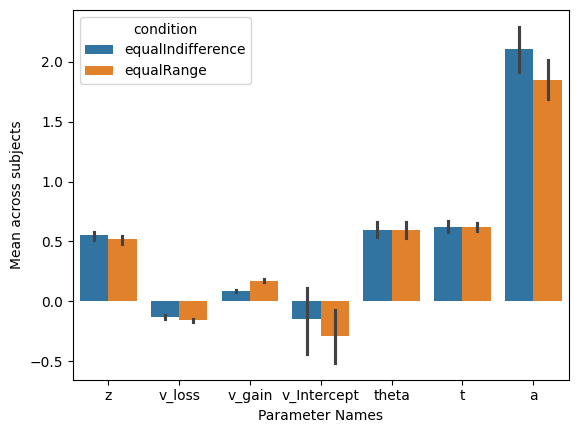

In [108]:
sns.barplot(data=all_params_fit, x="param_name", y="mean", hue="condition", errorbar=('ci', 95))
plt.xlabel("Parameter Names")
plt.ylabel("Mean across subjects")
plt.show()

### Correlation between parameters within condition
**Question: How do the parameters correlate within condition?**

In [116]:
# For each param_name, create a column with their mean across subjects
param_fit_col = all_params_fit.pivot(index=["sub", "condition"], columns="param_name", values="mean").reset_index()

Equal Range Condition


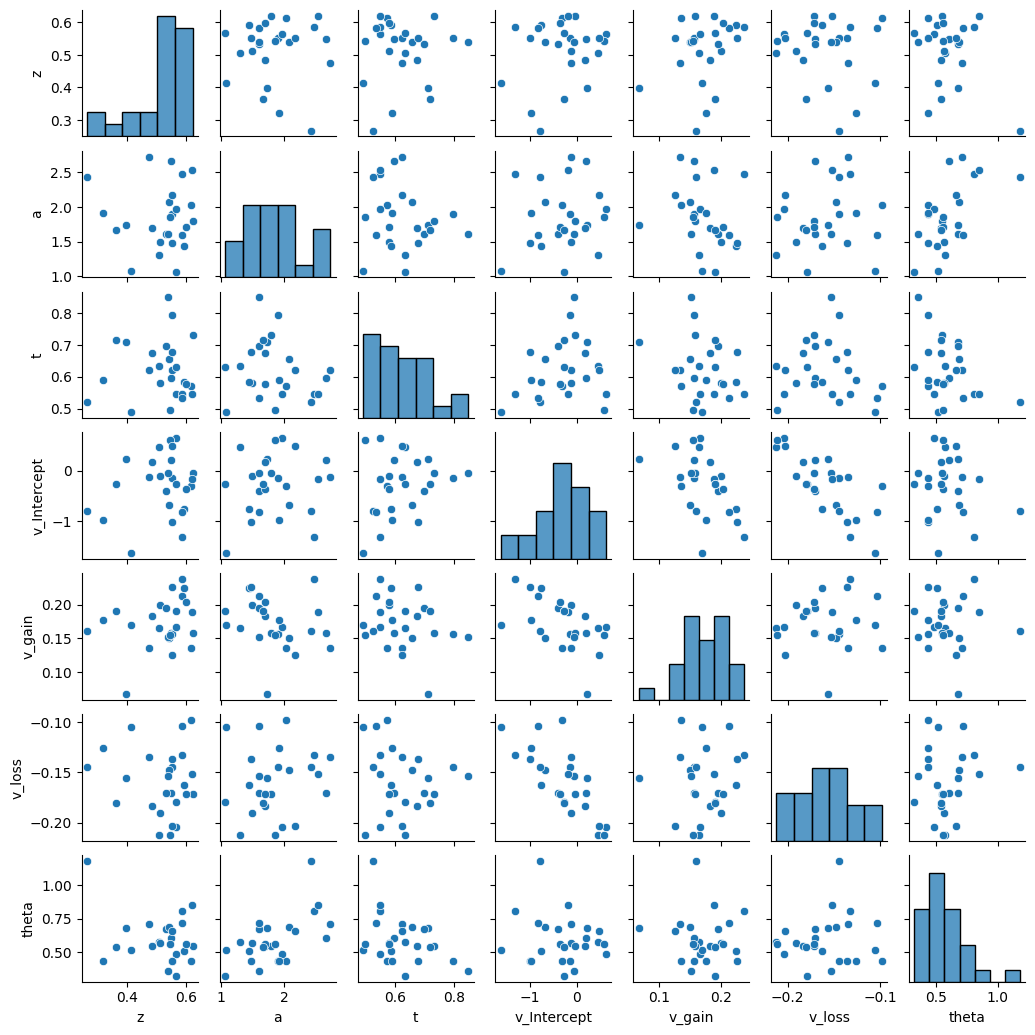

In [127]:
# Create a small figure to put the sns.pairplot in
print("Equal Range Condition")
equalRange_params = param_fit_col.query("condition == 'equalRange'")[["z", "a", "t", "v_Intercept", "v_gain", "v_loss", "theta"]]
sns.pairplot(equalRange_params, height = 1.5)
plt.show()

Equal Indifference Condition


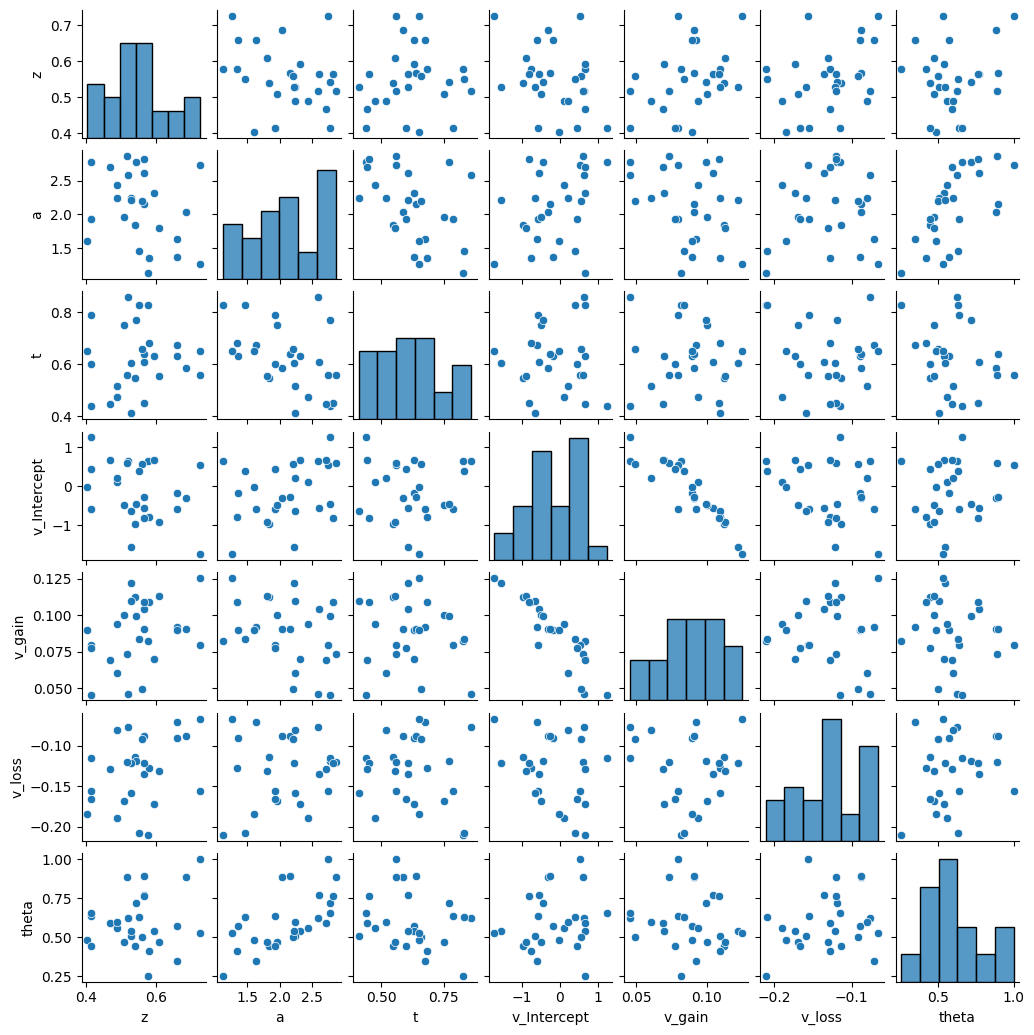

In [128]:
print("Equal Indifference Condition")
equalIndiff_params = param_fit_col.query("condition == 'equalIndifference'")[["z", "a", "t", "v_Intercept", "v_gain", "v_loss", "theta"]]
sns.pairplot(equalIndiff_params, height = 1.5)
plt.show()

In [163]:
print("Equal Range Condition")
rho = equalRange_params.corr()
pval = equalRange_params.corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(*rho.shape)
pval = pd.DataFrame(stats.false_discovery_control(pval, axis = None).reshape(pval.shape), columns=pval.columns, index=pval.index)
p = pval.map(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

Equal Range Condition


param_name,z,a,t,v_Intercept,v_gain,v_loss,theta
param_name,,,,,,,
z,1.0***,-0.01,0.03,0.2,0.27,-0.1,-0.3
a,-0.01,1.0***,-0.16,0.14,-0.23,0.12,0.58**
t,0.03,-0.16,1.0***,0.24,-0.25,-0.12,-0.39
v_Intercept,0.2,0.14,0.24,1.0***,-0.5*,-0.76***,-0.15
v_gain,0.27,-0.23,-0.25,-0.5*,1.0***,0.08,-0.04
v_loss,-0.1,0.12,-0.12,-0.76***,0.08,1.0***,0.1
theta,-0.3,0.58**,-0.39,-0.15,-0.04,0.1,1.0***


In [164]:
print("Equal Indifference Condition")
rho = equalIndiff_params.corr()
pval = equalIndiff_params.corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(*rho.shape)
pval = pd.DataFrame(stats.false_discovery_control(pval, axis = None).reshape(pval.shape), columns=pval.columns, index=pval.index)
p = pval.map(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

Equal Indifference Condition


param_name,z,a,t,v_Intercept,v_gain,v_loss,theta
param_name,,,,,,,
z,1.0***,-0.25,0.07,-0.33,0.35,0.36,0.19
a,-0.25,1.0***,-0.44,0.33,-0.34,0.12,0.64**
t,0.07,-0.44,1.0***,0.01,-0.1,-0.13,-0.21
v_Intercept,-0.33,0.33,0.01,1.0***,-0.89***,-0.27,0.15
v_gain,0.35,-0.34,-0.1,-0.89***,1.0***,-0.05,-0.14
v_loss,0.36,0.12,-0.13,-0.27,-0.05,1.0***,0.22
theta,0.19,0.64**,-0.21,0.15,-0.14,0.22,1.0***


**Findings:**
- For Low Reward condition (equalRange), the following parameters are significantly correlated:
    - Boundary separation (a) and theta (t) [Positively correlated**]
    - Fixed utility bias (v_intercept) and v_loss [Negatively correlated***]
    - Fixed utility bias (v_intercept) and v_gain [Negatively correlated*]
- For High Reward condition (equalIndifference), the following parameters are significantly correlated:
    - Boundary separation (a) and theta (t) [Positively correlated**]
    - Fixed utility bias (v_intercept) and v_gain [Negatively correlated***]

This suggests that, across conditions, larger boundary separation is associated with an increase in boundary shrinkage. Furthermore, in the low reward condition, higher fixed utility bias is associated with lower utility on losses. On the other hand, in the high reward condition, higher fixed utility bias is associated with lower utility on gains. 

To put it in simple words, in the low reward condition, lesser utility for the option with no consequences (i.e., I feel less inclined to reject the gamble generally) is associated with lower utility for losses (i.e., losses dont impact me that much to reject the gamble?). In the high reward condition, lesser utility for the option with no consequences (i.e., I feel less inclined to accept the gamble) is associated with lower utility for gains (i.e., gains dont impact me that much to accept the gamble?). 

**TODO:** Check if there is any differences in the correlation between parameters. 